In [1]:
import numpy as np, os, sys

import matplotlib.pyplot as plt #patch-wise similarities, droi images
from matplotlib import ticker, cm

import torch.nn as nn
import torch.utils.data 

import torch.optim
import torchvision

In [2]:
train_data = torchvision.datasets.FashionMNIST('data/', train=True, download=True, )#transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST('data/', train=False, download=True, )#transform=torchvision.transforms.ToTensor())

In [3]:
class FashionMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.X = x
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [4]:
dtrain = FashionMNISTDataset(train_data.data.view(train_data.data.size(0), -1).float(), train_data.targets)
dtest = FashionMNISTDataset(test_data.data.view(test_data.data.size(0), -1).float(), test_data.targets)

In [5]:
params = {'batch_size': 32, 'num_workers': 4}
idx_tr, idx_val = list(range(len(dtrain)))[:-10000], list(range(len(dtrain)))[-10000:]
tr_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_tr)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_val)
train_loader = torch.utils.data.DataLoader(dtrain, **params, sampler=tr_sampler)
val_loader = torch.utils.data.DataLoader(dtrain, **params, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(dtest, **params)

In [75]:
class Model(nn.Module):
    def __init__(self, d1, d2, din=28*28, dout=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(din, d1) # 300
        self.fc2 = torch.nn.Linear(d1, d2) # 100
        self.out = torch.nn.Linear(d2, dout) # 10

    def forward(self, x):

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        output = torch.softmax(self.out(x), dim=1)
        return output

In [76]:

def train_epoch(model,  trainloader,  criterion, device, optimizer ):
    model.train()
 
    losses = list()
    for batch_idx, data in enumerate(trainloader):

        inputs=data[0].to(device)
        labels=data[1].to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    return losses


def evaluate(model, dataloader, criterion, device):

    model.eval()

    losses, accs = [], []
    with torch.no_grad():
        for ctr, data in enumerate(dataloader):
            inputs = data[0].to(device)        
            outputs = model(inputs)
            labels = data[1]
            cpuout= outputs.to('cpu')
            loss = criterion(outputs, labels)
            _, preds = torch.max(cpuout, 1)
            accs.append( torch.sum(preds == labels.data).item()/len(labels.data) )
            losses.append(loss.item())

    return sum(accs)/len(accs), sum(losses)/len(losses)


def train_modelcv(dataloader_cvtrain, dataloader_cvtest, dataloader_cvval, model ,  criterion, optimizer, scheduler, num_epochs, device):

    best_measure = 0
    best_epoch =-1
    tr_loss, v_loss, te_loss = [], [], []
    tr_acc, v_acc, te_acc = [], [], []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train(True)
        losses=train_epoch(model,  dataloader_cvtrain,  criterion,  device , optimizer )

        model.train(False)
        train_acc, train_loss = evaluate(model, dataloader_cvtrain, criterion, device)
        val_acc, val_loss = evaluate(model, dataloader_cvval, criterion, device)
        test_acc, test_loss = evaluate(model, dataloader_cvtest, criterion, device)
        tr_loss.append(train_loss)
        v_loss.append(val_loss)
        te_loss.append(test_loss)
        tr_acc.append(train_acc)
        v_acc.append(val_acc)
        te_acc.append(test_acc)
        measure = val_acc
        if measure > best_measure: #higher is better or lower is better?
            bestweights= model.state_dict()
            best_measure = measure
            best_epoch = epoch
            print('current best', measure, ' at epoch ', best_epoch)

    return best_epoch, best_measure, bestweights, tr_loss, v_loss, te_loss, tr_acc, v_acc, te_acc

In [77]:
batch_size=32
#validation batch size
valbatch_size=32
# number of epochs for training
maxnumepochs=5
# learning rate
learningrate=0.005
device=torch.device('cpu')

In [78]:
model = Model(300, 100).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=learningrate, momentum=0.0, weight_decay=0)

In [79]:
best_epoch, best_perfmeasure, bestweights, tr_loss, v_loss, te_loss, tr_acc, v_acc, te_acc = train_modelcv(train_loader, test_loader, val_loader, model, criterion, 
                                                          optimizer, scheduler=None, num_epochs=maxnumepochs, device=device)
model.load_state_dict(bestweights)

Epoch 0/4
----------
current best 0.3872803514376997  at epoch  0
Epoch 1/4
----------
current best 0.6388777955271565  at epoch  1
Epoch 2/4
----------
current best 0.65625  at epoch  2
Epoch 3/4
----------
Epoch 4/4
----------


<All keys matched successfully>

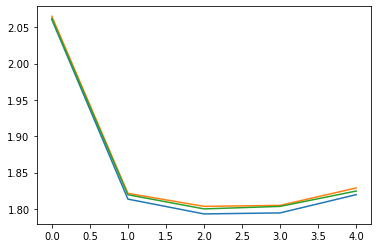

In [88]:
plt.plot(list(range(5)), tr_loss)
plt.savefig('train-loss.png')
plt.plot(list(range(5)), v_loss)
plt.savefig('val-loss.png')
plt.plot(list(range(5)), te_loss)
plt.savefig('test-loss.png')

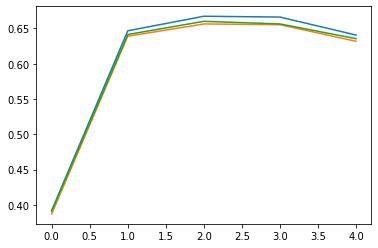

In [87]:
plt.plot(list(range(5)), tr_acc)
plt.savefig('train-acc.png')
plt.plot(list(range(5)), v_acc)
plt.savefig('val-acc.png')
plt.plot(list(range(5)), te_acc)
plt.savefig('test-acc.png')

When you train a deep neural net, then you get after every epoch one model (actually after every minibatch). Why you should not select the best model over all epochs on the test dataset?

Because validation set is used to select the correct hyperparameters such as which model we want to make, then we evaluate on the test set so we can know how the model performs to unseen dataset.
If we choose the best model on the testset, and we fine tune the model on the test set, we are overfiting it to the test set, therefore we cannot get a relative good estimate of models' performance on the test dataset.